In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/Shareddrives/DD/FINAL AI/Fruit Classification/Train"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix



In [ ]:
# Define hyperparameters
batch_size = 32
img_height = 100
img_width = 100
dropout_rate = 0.2
n_channels=3
# Define the input shape of your images
input_shape = (img_width, img_height, n_channels)

# Tasks and Marks Division-CNN

## Data Understanding, Analysis, Visualization and Cleaning[5]:

How many total images are in the dataset?

In [ ]:
# Initialize a variable to store the total number of images
total_images = 0

# Iterate over the directory and its subdirectories
for root, dirs, files in os.walk(data_path):
    # Count the number of files in each directory
    num_files = len(files)
    # Add the number of files to the total_images variable
    total_images += num_files

# Print the total number of images
print("Total number of images:", total_images)


Total number of images: 6277


How many images per class?

In [ ]:
# Count images per class
classes = os.listdir(data_path)
images_per_class = {}
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        images_per_class[class_name] = len(os.listdir(class_path))
print("Total number of images per classes:", images_per_class)

Total number of images per classes: {'Mango': 915, 'Cherry': 1229, 'Peach': 1229, 'Grape': 1475, 'Banana': 1429}


How do you split between validation and train set?

In [ ]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     directory=data_path,
#     labels='inferred',  # Automatically infer labels from subdirectories
#     label_mode='categorical',  # Use 'categorical' for multiple classes, 'binary' for two classes
#     image_size=(180, 180),  # Resize images to this size
#     batch_size=32,  # Number of images in each batch
#     shuffle=True,  # Shuffle the dataset
#     seed=42,  # Set a seed for reproducibility
#     validation_split=0.2,  # Percentage of data to use for validation
#     subset='training'  # Choose between 'training' and 'validation'
# )


train_ds Data Generator:
This data generator is used for training. It creates batches of training images and their corresponding labels.

In [ ]:
# val_ds = tf.keras.utils.image_dataset_from_directory(
#     directory=data_path,
#     labels='inferred',  # Automatically infer labels from subdirectories
#     label_mode='categorical',  # Use 'categorical' for multiple classes, 'binary' for two classes
#     image_size=(180, 180),  # Resize images to this size
#     batch_size=32,  # Number of images in each batch
#     shuffle=False,  # Do not shuffle the dataset for validation
#     seed=42,  # Set a seed for reproducibility
#     validation_split=0.5,  # Percentage of data to use for validation
#     subset='validation'  # Specify 'validation' subset
# )

val_ds Data Generator:
This data generator is used for validation. It creates batches of validation images and their corresponding labels.

# Data Augumentation

In [ ]:
# Define the ImageDataGenerator for the training data
train_datagen = ImageDataGenerator(
rescale=1./255,
validation_split=0.2,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.1,
horizontal_flip=True,
fill_mode='nearest'
)
train_ds = train_datagen.flow_from_directory(
directory=data_path,
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical',
subset='training'
)


Found 5024 images belonging to 5 classes.


In [ ]:
val_datagen = ImageDataGenerator(
rescale=1./255,
validation_split=0.2
)
val_ds = val_datagen.flow_from_directory(
directory=data_path,
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical',
subset='validation'
)


Found 1253 images belonging to 5 classes.


# Visualization

In [ ]:
# Printing out number of Classes
indices = train_ds.class_indices
class_names = list(indices.keys())
print(class_names)

['Banana', 'Cherry', 'Grape', 'Mango', 'Peach']


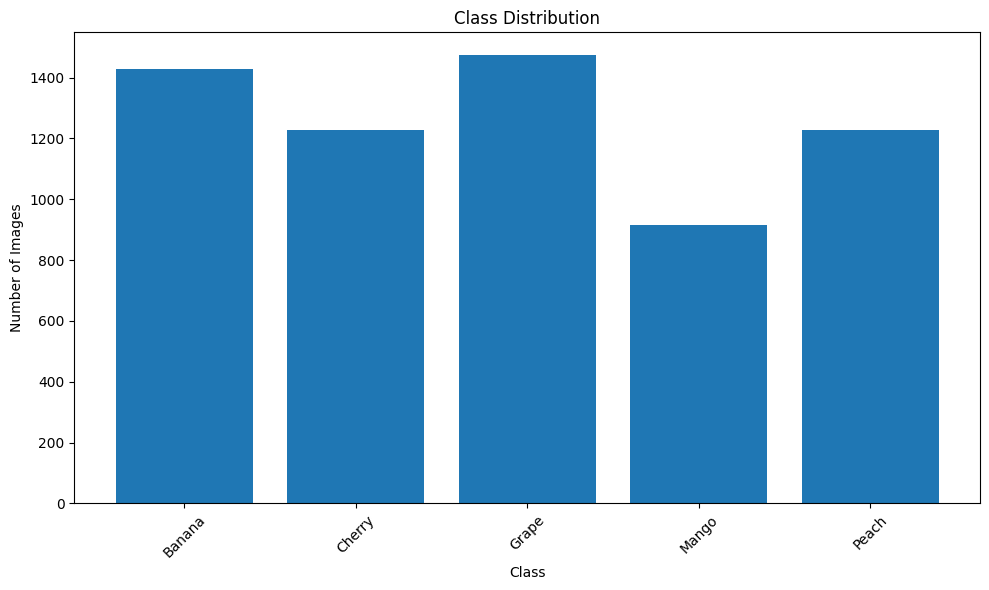

In [ ]:
# Get class names from subdirectories
class_names = sorted(os.listdir(data_path))

# Count the number of images per class
class_counts = [len(os.listdir(os.path.join(data_path, class_name))) for class_name in class_names]

# Create a bar chart to visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


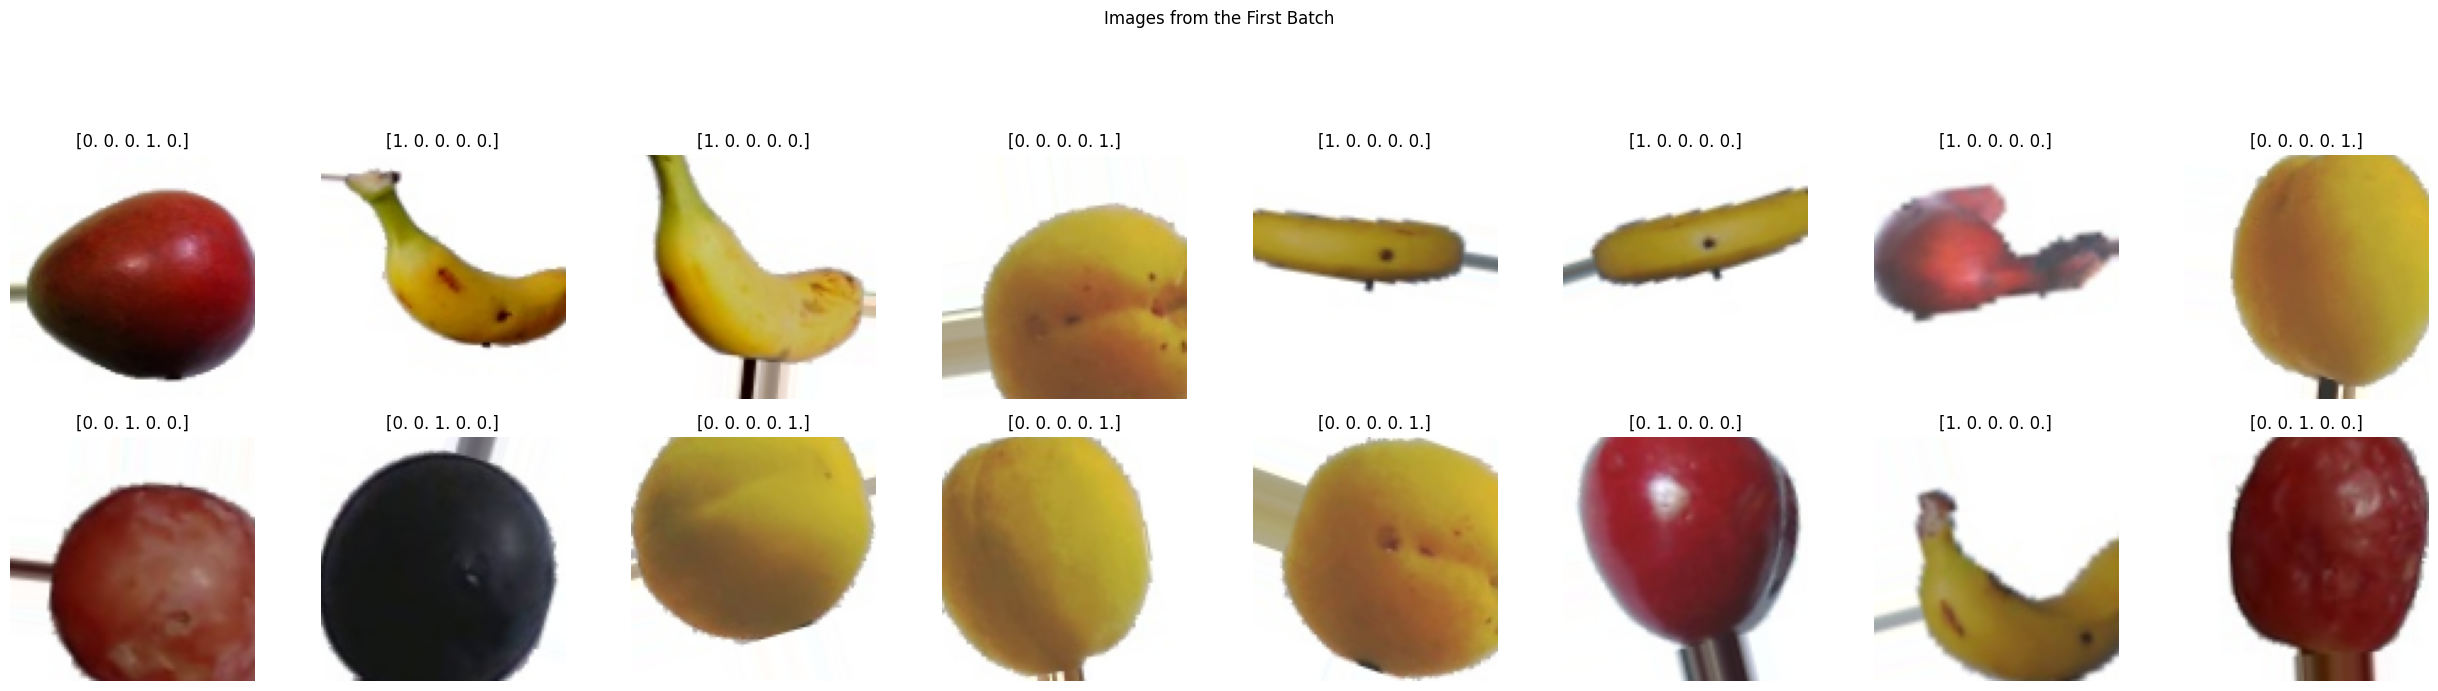

In [ ]:
# Visualize the images from the first batch
batch_images, batch_labels = next(train_ds)
plt.figure(figsize=(25, 25))
for i in range(16):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(batch_images[i])
    plt.title(batch_labels[i])
    plt.axis('off')
plt.suptitle('Images from the First Batch')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

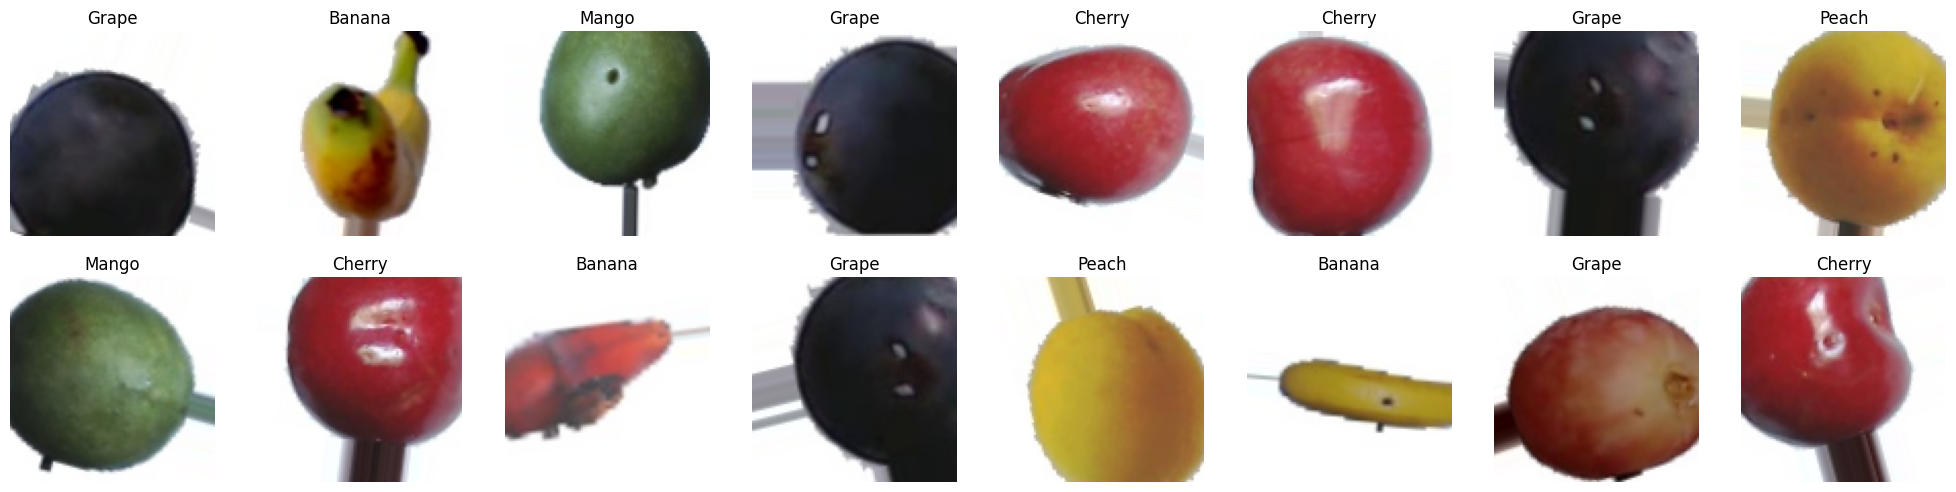

In [ ]:
# Display images with labels
plt.figure(figsize=(25, 25))
batch_images, batch_labels = next(train_ds)
for i in range(16):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(batch_images[i])
        plt.title(class_names[tf.argmax(batch_labels[i])])  # Convert one-hot encoded label to class name
        plt.axis("off")

plt.show()


# Build Model

In [ ]:
def generate_model(image_height, image_width, nchannels, num_classes):
  """
  This function will generate a model with set of hyperparameters defined above.
  Input Args:
  image_height[int] = Height of an image.
  image_width[int] = Width of an image.
  nchannels[int] = Number of channels in image.
  num_classes[int] = Number of classes in dataset.
  Output Args:
  model-> A CNN model.
  """
  model = tf.keras.Sequential([
      # Rescaling and input layer, [For keras the input shape must be(image height, image width, channels)]
      layers.Rescaling(1./255, input_shape=(image_height,image_width, nchannels)),
      # First Block of Convolution and Pooling Operations.
      layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
      layers.MaxPooling2D(),
      # Second Block of Convolution and Pooling Operations.
      layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
      layers.MaxPooling2D(),

      # Fully connected classifier.
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dropout(0.5),
      layers.BatchNormalization(),
      layers.Dense(num_classes, activation='softmax')
  ])
  return model
num_classes = len(class_names)
model = generate_model(img_height, img_width, 3, num_classes)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 40000)            

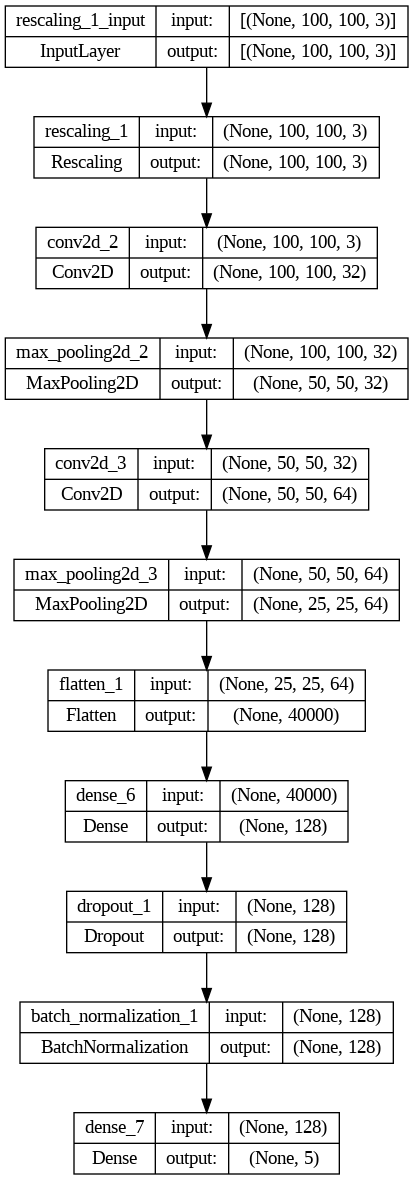

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

# Training of the Model

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
class Earlystopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy")>0.95):
      print('\nLoss is low so stop training')
      self.model.stop_training =True

In [ ]:
callbacks=Earlystopping()

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)


Epoch 1/10
157/157 [==============================] - 28s 167ms/step - loss: 0.9681 - accuracy: 0.5924 - val_loss: 1.2986 - val_accuracy: 0.4812
Epoch 2/10
157/157 [==============================] - 26s 167ms/step - loss: 0.7111 - accuracy: 0.6992 - val_loss: 0.9667 - val_accuracy: 0.5666
Epoch 3/10
157/157 [==============================] - 27s 173ms/step - loss: 0.5985 - accuracy: 0.7613 - val_loss: 1.1842 - val_accuracy: 0.5978
Epoch 4/10
157/157 [==============================] - 26s 163ms/step - loss: 0.5006 - accuracy: 0.8171 - val_loss: 0.5888 - val_accuracy: 0.7318
Epoch 5/10
157/157 [==============================] - 26s 164ms/step - loss: 0.3679 - accuracy: 0.8646 - val_loss: 0.3184 - val_accuracy: 0.8571
Epoch 6/10
157/157 [==============================] - 26s 166ms/step - loss: 0.3190 - accuracy: 0.8867 - val_loss: 0.3927 - val_accuracy: 0.8372
Epoch 7/10
157/157 [==============================] - 25s 161ms/step - loss: 0.3117 - accuracy: 0.8883 - val_loss: 0.1529 - val_ac

In [ ]:
# Save the trained model
model.save('/content/drive/Shareddrives/DD/FINAL AI/Save_Model.h5')

# Evaluate the model:

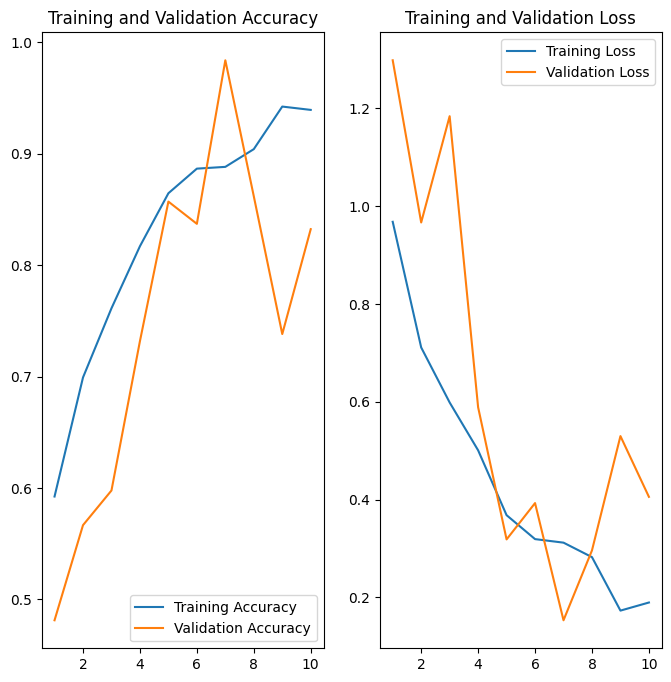

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the lengths of the arrays to match the actual number of epochs executed
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

40/40 [==============================] - 3s 64ms/step - loss: 0.4054 - accuracy: 0.8324
Test Loss: 0.4054282009601593
Test Accuracy: 0.832402229309082


# Results and Prediction:

In [ ]:
model = load_model('/content/drive/Shareddrives/DD/FINAL AI/Save_Model.h5')

1/1 [==============================] - 0s 127ms/step
Image 1_100(2).jpg belongs to class: Banana


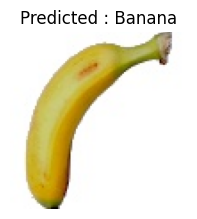

1/1 [==============================] - 0s 28ms/step
Image 5_100.jpg belongs to class: Cherry


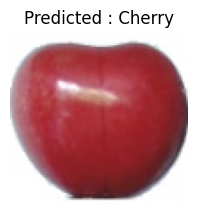

1/1 [==============================] - 0s 27ms/step
Image 14_100.jpg belongs to class: Grape


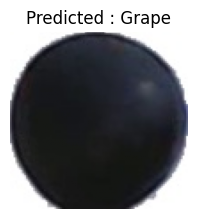

1/1 [==============================] - 0s 27ms/step
Image 11_100.jpg belongs to class: Cherry


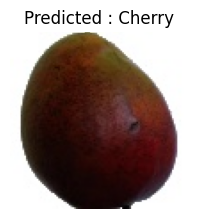

1/1 [==============================] - 0s 32ms/step
Image 26_100.jpg belongs to class: Mango


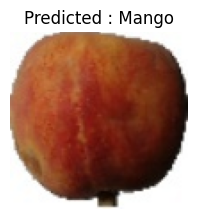

In [ ]:
image_dir = '/content/drive/Shareddrives/DD/FINAL AI/Fruit Classification/Test/'

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Preprocess the images and make predictions
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    img = Image.open(image_path)
    img = img.resize((img_width, img_height))
    img = np.array(img) / 255.0  # Normalize pixel values

    preprocessed_image = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_label = class_names[predicted_class_index]

    print(f"Image {image_file} belongs to class: {predicted_class_label}")
    plt.figure(figsize=(4, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Predicted : {predicted_class_label}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


40/40 [==============================] - 2s 56ms/step


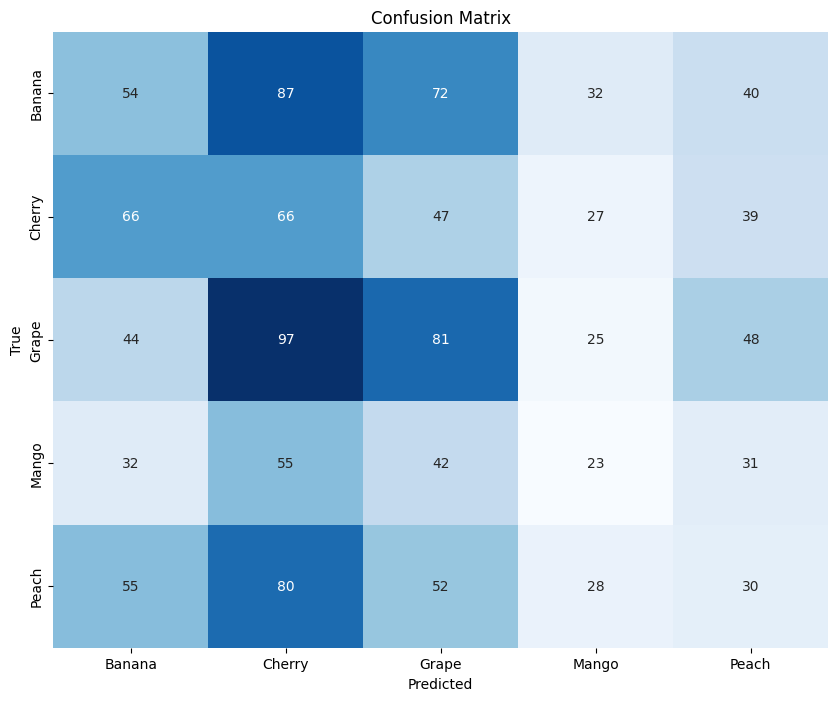

In [ ]:
# Make predictions on the test dataset
y_pred = model.predict(val_ds)
y_pred_labels = np.argmax(y_pred, axis=1) # Convert predicted probabilities to class labels
# Get the true labels for the test dataset
true_labels = val_ds.classes
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)
# Get the class labels
class_labels = list(val_ds.class_indices.keys())
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **Fine Tuning**

In [ ]:


# Load a pretrained model (VGG16 in this example)
base_model = VGG16(weights='imagenet', include_top=False)  # Load without the top (classifier) layers

# Freeze the layers of the base model to retain prelearned features
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(256, activation='relu')(x)  # Add your own dense layers
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer






In [ ]:
model.summary()
# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 40000)            

In [ ]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True )

# Fine-tuning: Train the new layers while keeping the base model layers frozen
history=model.fit(train_ds, epochs=10, batch_size=32, validation_data=(val_ds), callbacks=[early_stopping])

Epoch 1/10
157/157 [==============================] - 31s 189ms/step - loss: 0.5424 - accuracy: 0.8465 - val_loss: 0.2082 - val_accuracy: 0.9753
Epoch 2/10
157/157 [==============================] - 29s 184ms/step - loss: 0.1378 - accuracy: 0.9743 - val_loss: 0.0748 - val_accuracy: 0.9960
Epoch 3/10
157/157 [==============================] - 28s 178ms/step - loss: 0.0742 - accuracy: 0.9857 - val_loss: 0.0627 - val_accuracy: 0.9888
Epoch 4/10
157/157 [==============================] - 28s 178ms/step - loss: 0.0471 - accuracy: 0.9924 - val_loss: 0.0426 - val_accuracy: 0.9968
Epoch 5/10
157/157 [==============================] - 29s 184ms/step - loss: 0.0356 - accuracy: 0.9938 - val_loss: 0.0447 - val_accuracy: 0.9832
Epoch 6/10
157/157 [==============================] - 27s 174ms/step - loss: 0.0354 - accuracy: 0.9912 - val_loss: 0.0448 - val_accuracy: 0.9880


In [ ]:
# Save the trained model
model.save('/content/drive/Shareddrives/DD/FINAL AI/After_Tuning_Model.h5')

In [ ]:
# # Unfreeze some of the top layers and continue training for fine-tuning
# for layer in base_model.layers[-15:]:  # Unfreeze the last 15 layers
#     layer.trainable = True

# model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Continue training for more epochs
# model.fit(train_ds, epochs=10, batch_size=32, validation_data=(val_ds))

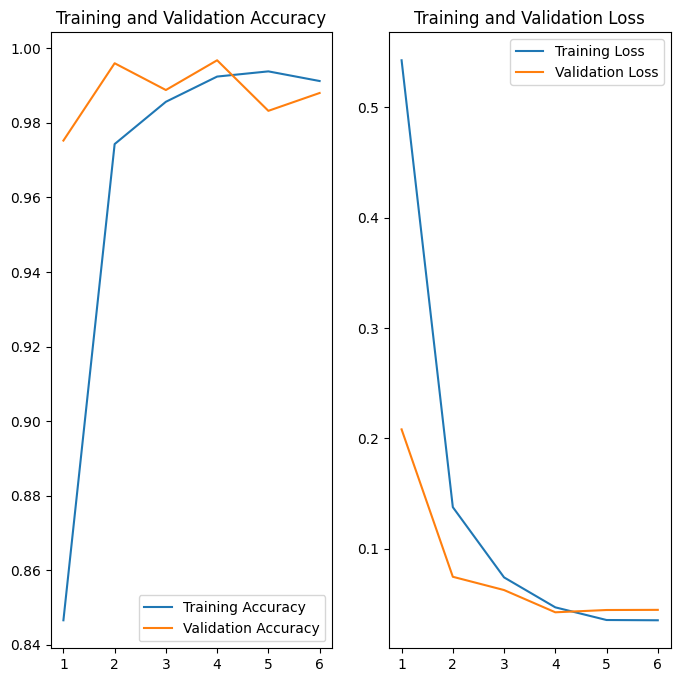

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the lengths of the arrays to match the actual number of epochs executed
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

40/40 [==============================] - 2s 61ms/step - loss: 0.0426 - accuracy: 0.9968
Test Loss: 0.04259977117180824
Test Accuracy: 0.9968076348304749


In [ ]:
model = load_model('/content/drive/Shareddrives/DD/FINAL AI/After_Tuning_Model.h5')

In [ ]:
image_dir = '/content/drive/Shareddrives/DD/FINAL AI/Fruit Classification/Test/'

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Preprocess the images and make predictions
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    img = Image.open(image_path)
    img = img.resize((img_width, img_height))
    img = np.array(img) / 255.0  # Normalize pixel values

    preprocessed_image = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_label = class_names[predicted_class_index]

    print(f"Image {image_file} belongs to class: {predicted_class_label}")

1/1 [==============================] - 0s 205ms/step
Image 1_100(2).jpg belongs to class: Banana
1/1 [==============================] - 0s 26ms/step
Image 5_100.jpg belongs to class: Cherry
1/1 [==============================] - 0s 27ms/step
Image 14_100.jpg belongs to class: Grape
1/1 [==============================] - 0s 34ms/step
Image 11_100.jpg belongs to class: Mango
1/1 [==============================] - 0s 29ms/step
Image 26_100.jpg belongs to class: Peach


40/40 [==============================] - 3s 68ms/step


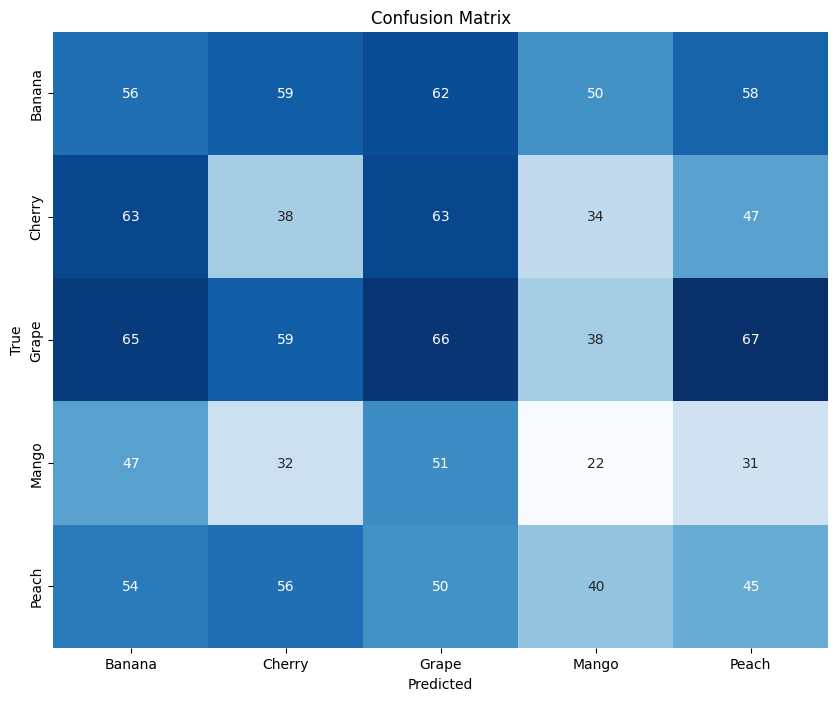

In [ ]:
# Make predictions on the test dataset
y_pred = model.predict(val_ds)
y_pred_labels = np.argmax(y_pred, axis=1) # Convert predicted probabilities to class labels
# Get the true labels for the test dataset
true_labels = val_ds.classes
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)
# Get the class labels
class_labels = list(val_ds.class_indices.keys())
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()